# Avalanche Prediction System
This project aims to extract weather and avalanche data from a number of CSV files, format and normalise the data, train a number of LSTM models to predict the occurance of an avalanche and evaluate the performance of each model. Please ensure that every code block is run in order to produce the correct result. 

## Initialising Variables
Empty lists are used to store the hourly weather data values from the NCEI dataset

In [81]:
# Import data processing packages
import numpy as np
import csv
import matplotlib.pyplot as plt
import math

# Import ML packages
import keras.backend as K
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation, RNN
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.utils.fixes import signature
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

## Importing Avalanche Data
Some of the avalanche data is missing or contains errors. When reading in the data, these problems must be accounted for before storing the data into the relavent lists.

In [82]:
# Initialising empty lists for avi data
avi_stn = []
avi_date = []
avi_depth = []
avi_width = []
avi_aspect = []
avi_trigger = []
avi_elevation = []
counter = 0

# Reading weather data from file
with open('Data/Utah/Avalanches/avalanches.csv') as avalanche_data:
    avalanches = csv.DictReader(avalanche_data)
    for row in avalanches:
        avi_stn.append(row['Region'])
        if(len(row['Date']) != 0):
            
            # Importing date info
            # Date restructure required from CSV file format
            if(row['Date'][1] == "/" and row['Date'][3] == "/"):
                avi_date.append(row['Date'][-4:] + '/0' + row['Date'][0] + '/0' + row['Date'][2])
            elif(row['Date'][1] == "/" and row['Date'][4] == "/"):
                avi_date.append(row['Date'][-4:] + '/0' + row['Date'][0] + "/" + row['Date'][2:4])
            elif(row['Date'][2] == "/" and row['Date'][4] == "/"):
                avi_date.append(row['Date'][-4:] + "/" +row['Date'][:2] + '/0' + row['Date'][3])
            elif(row['Date'][2] == "/" and row['Date'][5] == "/"):
                avi_date.append(row['Date'][-4:] + "/" +row['Date'][:2] + "/" + row['Date'][3:5])
            
            
            # Importing avi trigger info
            if(row['Trigger'] == ""):
                avi_trigger.append("Unknown") 
            else:
                avi_trigger.append(row['Trigger']) 
                
            # Importing avi elevation info
            if(row['Elevation'] == ""):
                avi_trigger.append("Unknown") 
            else:
                avi_elevation.append(row['Elevation'])
                
            # Importing avi aspect info
            if(row['Aspect'] == ""):
                avi_trigger.append("Unknown") 
            else:
                avi_aspect.append(row['Aspect'])
        
            # Importing avi depth info
            if(row['Depth'] == ''):
                avi_depth.append(avi_depth[counter-1])
            elif(len(row['Depth']) > 2 and row['Depth'][-2] == "'"):
                avi_depth.append(row['Depth'][:-2])
            elif(row['Depth'][-1] == "'"):
                avi_depth.append(row['Depth'][:-1])
            else:
                avi_depth.append(row['Depth'])
            
            # Importing avi width info
            if(row['Width'] == ''):
                avi_width.append(avi_depth[counter-1])
            elif(row['Width'][-2] == "'"):
                avi_width.append(row['Width'][:-2])
            elif(row['Width'][-1] == "'"):
                avi_width.append(row['Width'][:-1])
            else:
                avi_width.append(row['Width'])
        
            counter += 1
        
print("Successfully imported avalanche data")        

Successfully imported avalanche data


In [83]:
# Update range where necessary
for x in range(1):
    print("Station: " + avi_stn[-x])
    print("Date: " + avi_date[-x])
    print("Depth: " + avi_depth[-x])
    print("Width: " + avi_width[-x])
    print("Aspect: " + avi_aspect[-x])
    print("Trigger: " + avi_trigger[-x])
    print("Elevation: " + avi_elevation[-x] + "\n") 

Station: Salt Lake
Date: 2019/03/11
Depth: 2"
Width: 100
Aspect: Northeast
Trigger: Unknown
Elevation: 10,200'



# Importing Weather Data
Some data within the dataset is erronious or missing. When reading data into the system, any unexpected characters must be accounted for. Each variable read from the CSV file is stored into the relavent hourly weather list for later manipulation.
## The first weather station to be imported is Logan

In [84]:
# Initialising empty lists to store hourly weather data
h_stn = []
h_date = []
h_precip = []
h_wtemp = []
h_dtemp = []
h_windspd = []
h_winddir = []
h_altimeter = []
h_dewpoint = []
h_stn_pressure = []
h_sea_pressure = []
h_humidity = []

hour = "-1"
day = ""
preday = ""
hours = 0

# Importing data from the Logan region
filepath = 'Data/Utah/Weather/logan_10yr_weather.csv'

In [85]:
# Reading weather data from file
with open(filepath) as station_weather:
    r_station = csv.DictReader(station_weather)
    for row in r_station:
        
        # Remove rogue station data 
        if(row['REPORT_TYPE'][0] != 'S'):
            
            # Ignore multiple reading for one hour
            if(row['DATE'][11:13] != hour):
                hours += 1
                
                # Check for new day
                if(row['DATE'][8:10] != day):
                    day = row['DATE'][8:10]
                    hours = 0
                    
                # Extracting station and date info
                hour = row['DATE'][11:13]
                h_stn.append("Logan")
                h_date.append(row['DATE'][:4] + "/" + row['DATE'][5:7] + "/" + row['DATE'][8:10])
            
                # Extracting Altimeter Data
                if(row['HourlyAltimeterSetting'] == ""):
                    h_altimeter.append(h_altimeter[-1])
                elif(row['HourlyAltimeterSetting'][-1] == "s"):
                    h_altimeter.append(float(row['HourlyAltimeterSetting'][:-1]))
                else:
                    h_altimeter.append(float(row['HourlyAltimeterSetting']))
            
                # Extracting Dew Point Data
                if(row['HourlyDewPointTemperature'] == ''):
                    h_dewpoint.append(h_dewpoint[-1])
                elif(row['HourlyDewPointTemperature'] == "*"):
                    h_dewpoint.append(0)
                elif(row['HourlyDewPointTemperature'][-1] == 's'):
                    h_dewpoint.append(int(row['HourlyDewPointTemperature'][:-1]))
                else:
                    h_dewpoint.append(int(row['HourlyDewPointTemperature']))
                
                # Extracting Dry Bulb Temp Data
                if(row['HourlyDryBulbTemperature'] == ''):
                    h_dtemp.append(h_dtemp[-1])
                    #print(row['REPORT_TYPE'] + " - "+ str(h_dtemp[-1]))
                elif(row['HourlyDryBulbTemperature'] == '*'):
                    h_dtemp.append(0)
                elif(row['HourlyDryBulbTemperature'][-1] == 's'):
                    h_dtemp.append(int(row['HourlyDryBulbTemperature'][:-1]))
                else:
                    h_dtemp.append(int(row['HourlyDryBulbTemperature']))
                
                # Extracting Precipitation Data
                if(row['HourlyPrecipitation'] == "" or row['HourlyPrecipitation'] == "T"):
                    h_precip.append(float(0))
                elif(row['HourlyPrecipitation'][-1] == "s"):
                    h_precip.append(float(row['HourlyPrecipitation'][:-1]))
                else:
                    h_precip.append(float(row['HourlyPrecipitation']))
                
                # Extracting Humidity Data
                if(row['HourlyRelativeHumidity'] == "" or row['HourlyRelativeHumidity'] == '*'):
                    h_humidity.append(h_humidity[-1])
                else:
                    h_humidity.append(int(row['HourlyRelativeHumidity']))
                
                # Extracting Sea Level Pressure Data
                if(row['HourlySeaLevelPressure'] == ""):
                    h_sea_pressure.append(h_sea_pressure[-1])
                elif(row['HourlySeaLevelPressure'][-1] == "s"):
                    h_sea_pressure.append(float(row['HourlySeaLevelPressure'][:-1]))
                else:
                    h_sea_pressure.append(float(row['HourlySeaLevelPressure']))
                
                # Extracting Station Level Pressure Data
                if(row['HourlyStationPressure'] == ""):
                    h_stn_pressure.append(h_stn_pressure[-1])
                elif(row['HourlyStationPressure'][-1]):
                    h_stn_pressure.append(float(row['HourlyStationPressure'][:-1]))
                else:
                    h_stn_pressure.append(float(row['HourlyStationPressure']))
               
                # Extracting Wet Bulb Temp Data
                if(row['HourlyWetBulbTemperature'] == "" or row['HourlyWetBulbTemperature'] == "*"):
                    h_wtemp.append(h_wtemp[-1])
                else:
                    h_wtemp.append(int(row['HourlyWetBulbTemperature']))
            
                # Extracting Wind Direction Data
                if(row['HourlyWindDirection'] == "" or row['HourlyWindDirection'] == "VRB"):
                    h_winddir.append(h_winddir[-1])
                else:
                    h_winddir.append(int(row['HourlyWindDirection']))
                
                # Extracting Wind Speed Data
                if(row['HourlyWindSpeed'] == ""):
                    h_windspd.append(h_windspd[-1])
                elif(row['HourlyWindSpeed'][-1] == "s"):
                    h_windspd.append(h_windspd[-1])
                else:
                    h_windspd.append(int(row['HourlyWindSpeed']))
                
            
print("Successfully imported weather data")

Successfully imported weather data


In [86]:
# Update range where necessary
for x in range(1):
    print("Station: " + h_stn[x])
    print("Date: " + str(h_date[x]))
    print("Precip: " + str(h_precip[x]))
    print("Temp: " + str(h_dtemp[x]))
    print("Wind Speed: " + str(h_windspd[x]))
    print("Wind Directon: " + str(h_winddir[x])) 
    print("Wet Temp: " + str(h_wtemp[x]))
    print("Dry Temp: " + str(h_dtemp[x]))
    print("Altimeter: " + str(h_altimeter[x]))
    print("Dewpoint: " + str(h_dewpoint[x]))
    print("Station Pressure: " + str(h_stn_pressure[x]))
    print("Sea Pressure: " + str(h_sea_pressure[x]))
    print("Humidity: " + str(h_humidity[x]) + "\n")

Station: Logan
Date: 2008/11/01
Precip: 0.0
Temp: 58
Wind Speed: 6
Wind Directon: 180
Wet Temp: 51
Dry Temp: 58
Altimeter: 30.34
Dewpoint: 44
Station Pressure: 25.7
Sea Pressure: 30.23
Humidity: 60



## Extracting Winter Season Data
The data proided by the NCEI spans an entire year, however much of that data is irrelavent to avalanche prediction. Therefore, the data must be filtered, removing any data from outside of the relavent ranges. Additioanlly, any missing data fields must be populated in order to optimise the neural network.

In [87]:
# Method to check if an avi occurred on a specific day
def check_avi(check_date):
    found = 0
    duplicate = 0
    for x in range(len(avi_date)):
        if(str(avi_date[x]) == str(check_date)):
            found = 1
    return found

# Initialising empty lists to store weather data 
stn = []
date = []
precip = []
wtemp = []
dtemp = []
windspd = []
winddir = []
altimeter = []
dewpoint = []
stn_pressure = []
sea_pressure = []
humidity = []
avi = []

# Initialising variables to define the range of useful data
start_year = "2009"
season_start = "/11/01"
season_end = "/06/01"
in_season = 0
in_range = 0
hours = 0
day = str(h_date[0])[4:]
days = 0


# Populates lists with weather data
# Hourly readings used and missing readings are filled
# Only data from the winter season is stored
# Data is converted to metric units
for x in range(len(h_stn)):
    # Check to see whether the current date is within the correct range
    if(str(h_date[x][:4]) == start_year):
        in_range = 1
    if(str(h_date[x])[4:]  == season_start and in_range == 1):
        in_season = 1
    elif(str(h_date[x])[4:] == season_end and in_range == 1):
        in_season = 0
        
    if(in_season == 1 and in_range == 1):
        hours += 1
        if(str(h_date[x])[4:] != day):
            # Populataes any missing data from the end of a day with readings from previous hour
            for i in range(24-hours):
                stn.append(h_stn[x-1])
                date.append(h_date[x-1])
                precip.append(h_precip[x-1]*2.54)
                wtemp.append((h_wtemp[x-1]-32)*5/9)
                dtemp.append((h_dtemp[x-1]-32)*5/9)
                windspd.append(h_windspd[x-1])
                winddir.append(h_winddir[x-1])
                altimeter.append(h_altimeter[x-1])
                dewpoint.append(h_dewpoint[x-1])
                stn_pressure.append(h_stn_pressure[x-1])
                sea_pressure.append(h_sea_pressure[x-1])
                humidity.append(h_humidity[x-1])
                
            day = str(h_date[x])[4:]
            days += 1
            avi.append(check_avi(h_date[x-1]))
            hours = 0
        
        # Populates lists with data from the hourly readings
        stn.append(h_stn[x])
        date.append(h_date[x])
        precip.append(h_precip[x]*2.54)
        wtemp.append((h_wtemp[x]-32)*5/9)
        dtemp.append((h_dtemp[x]-32)*5/9)
        windspd.append(h_windspd[x])
        winddir.append(h_winddir[x])
        altimeter.append(h_altimeter[x])
        dewpoint.append(h_dewpoint[x])
        stn_pressure.append(h_stn_pressure[x])
        sea_pressure.append(h_sea_pressure[x])
        humidity.append(h_humidity[x])
        
        if(x == len(h_stn)-1):
            avi.append(check_avi(h_date[x-1]))
print("Season filtering complete")

Season filtering complete


# The second station to be imported is Ogden

In [88]:
# Initialising empty lists to store hourly weather data
h_stn2 = []
h_date2 = []
h_precip2 = []
h_wtemp2 = []
h_dtemp2 = []
h_windspd2 = []
h_winddir2 = []
h_altimeter2 = []
h_dewpoint2 = []
h_stn_pressure2 = []
h_sea_pressure2 = []
h_humidity2 = []

hour = "-1"
day = ""
preday = ""
hours = 0

#filepath = 'Data/Utah/Weather/logan_10yr_weather.csv'
filepath = 'Data/Utah/Weather/ogden_10yr_weather.csv'
#filepath = 'Data/Utah/Weather/provo_10yr_weather.csv'
#filepath = 'Data/Utah/Weather/saltlakecity_10yr_weather.csv'

In [89]:
# Reading weather data from file
with open(filepath) as station_weather:
    r_station = csv.DictReader(station_weather)
    for row in r_station:
        
        # Remove rogue station data 
        if(row['REPORT_TYPE'][0] != 'S'):
            
            # Ignore multiple reading for one hour
            if(row['DATE'][11:13] != hour):
                hours += 1
                
                # Check for new day
                if(row['DATE'][8:10] != day):
                    day = row['DATE'][8:10]
                    hours = 0
                    
                # Extracting station and date info
                hour = row['DATE'][11:13]
                h_stn2.append("Moab")
                h_date2.append(row['DATE'][:4] + "/" + row['DATE'][5:7] + "/" + row['DATE'][8:10])
            
                # Extracting Altimeter Data
                if(row['HourlyAltimeterSetting'] == ""):
                    h_altimeter2.append(h_altimeter[-1])
                elif(row['HourlyAltimeterSetting'][-1] == "s"):
                    h_altimeter2.append(float(row['HourlyAltimeterSetting'][:-1]))
                else:
                    h_altimeter2.append(float(row['HourlyAltimeterSetting']))
            
                # Extracting Dew Point Data
                if(row['HourlyDewPointTemperature'] == ''):
                    h_dewpoint2.append(h_dewpoint[-1])
                elif(row['HourlyDewPointTemperature'] == "*"):
                    h_dewpoint2.append(0)
                elif(row['HourlyDewPointTemperature'][-1] == 's'):
                    h_dewpoint2.append(int(row['HourlyDewPointTemperature'][:-1]))
                else:
                    h_dewpoint2.append(int(row['HourlyDewPointTemperature']))
                
                # Extracting Dry Bulb Temp Data
                if(row['HourlyDryBulbTemperature'] == ''):
                    h_dtemp2.append(h_dtemp[-1])
                    #print(row['REPORT_TYPE'] + " - "+ str(h_dtemp[-1]))
                elif(row['HourlyDryBulbTemperature'] == '*'):
                    h_dtemp2.append(0)
                elif(row['HourlyDryBulbTemperature'][-1] == 's'):
                    h_dtemp2.append(int(row['HourlyDryBulbTemperature'][:-1]))
                else:
                    h_dtemp2.append(int(row['HourlyDryBulbTemperature']))
                
                # Extracting Precipitation Data
                if(row['HourlyPrecipitation'] == "" or row['HourlyPrecipitation'] == "T"):
                    h_precip2.append(float(0))
                elif(row['HourlyPrecipitation'][-1] == "s"):
                    h_precip2.append(float(row['HourlyPrecipitation'][:-1]))
                else:
                    h_precip2.append(float(row['HourlyPrecipitation']))
                
                # Extracting Humidity Data
                if(row['HourlyRelativeHumidity'] == "" or row['HourlyRelativeHumidity'] == '*'):
                    h_humidity2.append(h_humidity[-1])
                else:
                    h_humidity2.append(int(row['HourlyRelativeHumidity']))
                
                # Extracting Sea Level Pressure Data
                if(row['HourlySeaLevelPressure'] == ""):
                    h_sea_pressure2.append(h_sea_pressure[-1])
                elif(row['HourlySeaLevelPressure'][-1] == "s"):
                    h_sea_pressure2.append(float(row['HourlySeaLevelPressure'][:-1]))
                else:
                    h_sea_pressure2.append(float(row['HourlySeaLevelPressure']))
                
                # Extracting Station Level Pressure Data
                if(row['HourlyStationPressure'] == ""):
                    h_stn_pressure2.append(h_stn_pressure[-1])
                elif(row['HourlyStationPressure'][-1]):
                    h_stn_pressure2.append(float(row['HourlyStationPressure'][:-1]))
                else:
                    h_stn_pressure2.append(float(row['HourlyStationPressure']))
               
                # Extracting Wet Bulb Temp Data
                if(row['HourlyWetBulbTemperature'] == "" or row['HourlyWetBulbTemperature'] == "*"):
                    h_wtemp2.append(h_wtemp[-1])
                else:
                    h_wtemp2.append(int(row['HourlyWetBulbTemperature']))
            
                # Extracting Wind Direction Data
                if(row['HourlyWindDirection'] == "" or row['HourlyWindDirection'] == "VRB"):
                    h_winddir2.append(h_winddir[-1])
                else:
                    h_winddir2.append(int(row['HourlyWindDirection']))
                
                # Extracting Wind Speed Data
                if(row['HourlyWindSpeed'] == ""):
                    h_windspd2.append(h_windspd[-1])
                elif(row['HourlyWindSpeed'][-1] == "s"):
                    h_windspd2.append(h_windspd[-1])
                else:
                    h_windspd2.append(int(row['HourlyWindSpeed']))
                
            
print("Successfully imported weather data")
print(h_stn2[0])

Successfully imported weather data
Moab


## Extracting winter season data

In [90]:
# Initialising empty lists to store weather data 
stn2 = []
date2 = []
precip2 = []
wtemp2 = []
dtemp2 = []
windspd2 = []
winddir2 = []
altimeter2 = []
dewpoint2 = []
stn_pressure2 = []
sea_pressure2 = []
humidity2 = []
avi2 = []

# Initialising variables to define the range of useful data
start_year = "2009"
season_start = "/11/01"
season_end = "/06/01"
in_season = 0
in_range = 0
hours = 0
day = str(h_date2[0])[4:]
days = 0


# Populates lists with weather data
# Hourly readings used and missing readings are filled
# Only data from the winter season is stored
# Data is converted to metric units
for x in range(len(h_stn2)):
    # Check to see whether the current date is within the correct range
    if(str(h_date2[x][:4]) == start_year):
        in_range = 1
    if(str(h_date2[x])[4:]  == season_start and in_range == 1):
        in_season = 1
    elif(str(h_date2[x])[4:] == season_end and in_range == 1):
        in_season = 0
        
    if(in_season == 1 and in_range == 1):
        hours += 1
        if(str(h_date2[x])[4:] != day):
            # Populataes any missing data from the end of a day with readings from previous hour
            for i in range(24-hours):
                stn2.append(h_stn2[x-1])
                date2.append(h_date2[x-1])
                precip2.append(h_precip2[x-1]*2.54)
                wtemp2.append((h_wtemp2[x-1]-32)*5/9)
                dtemp2.append((h_dtemp2[x-1]-32)*5/9)
                windspd2.append(h_windspd2[x-1])
                winddir2.append(h_winddir2[x-1])
                altimeter2.append(h_altimeter2[x-1])
                dewpoint2.append(h_dewpoint2[x-1])
                stn_pressure2.append(h_stn_pressure2[x-1])
                sea_pressure2.append(h_sea_pressure2[x-1])
                humidity2.append(h_humidity2[x-1])
                
            day = str(h_date2[x])[4:]
            days += 1
            avi2.append(check_avi(h_date2[x-1]))
            hours = 0
        
        # Populates lists with data from the hourly readings
        stn2.append(h_stn2[x])
        date2.append(h_date2[x])
        precip2.append(h_precip2[x]*2.54)
        wtemp2.append((h_wtemp2[x]-32)*5/9)
        dtemp2.append((h_dtemp2[x]-32)*5/9)
        windspd2.append(h_windspd2[x])
        winddir2.append(h_winddir2[x])
        altimeter2.append(h_altimeter2[x])
        dewpoint2.append(h_dewpoint2[x])
        stn_pressure2.append(h_stn_pressure2[x])
        sea_pressure2.append(h_sea_pressure2[x])
        humidity2.append(h_humidity2[x])
        
        if(x == len(h_stn2)-1):
            avi2.append(check_avi(h_date2[x-1]))
print("Season filtering complete")

Season filtering complete


In [91]:
for x in range(1):
    print("Station: " + h_stn2[x])
    print("Date: " + str(h_date2[x]))
    print("Precip: " + str(h_precip2[x]))
    print("Temp: " + str(h_dtemp2[x]))
    print("Wind Speed: " + str(h_windspd2[x]))
    print("Wind Directon: " + str(h_winddir2[x])) 
    print("Wet Temp: " + str(wtemp2[x]))
    print("Dry Temp: " + str(dtemp2[x]))
    print("Altimeter: " + str(h_altimeter2[x]))
    print("Dewpoint: " + str(h_dewpoint2[x]))
    print("Station Pressure: " + str(h_stn_pressure2[x]))
    print("Sea Pressure: " + str(h_sea_pressure2[x]))
    print("Humidity: " + str(h_humidity2[x]) + "\n")

Station: Moab
Date: 2008/11/01
Precip: 0.03
Temp: 54
Wind Speed: 7
Wind Directon: 120
Wet Temp: 3.888888888888889
Dry Temp: 7.222222222222222
Altimeter: 30.36
Dewpoint: 48
Station Pressure: 25.3
Sea Pressure: 30.19
Humidity: 82



## The third station to be imported is Provo

In [92]:
# Initialising empty lists to store hourly weather data
h_stn3 = []
h_date3 = []
h_precip3 = []
h_wtemp3 = []
h_dtemp3 = []
h_windspd3 = []
h_winddir3 = []
h_altimeter3 = []
h_dewpoint3 = []
h_stn_pressure3 = []
h_sea_pressure3 = []
h_humidity3 = []

hour = "-1"
day = ""
preday = ""
hours = 0

filepath = 'Data/Utah/Weather/provo_10yr_weather.csv'

In [93]:
# Reading weather data from file
with open(filepath) as station_weather:
    r_station = csv.DictReader(station_weather)
    for row in r_station:
        
        # Remove rogue station data 
        if(row['REPORT_TYPE'][0] != 'S'):
            
            # Ignore multiple reading for one hour
            if(row['DATE'][11:13] != hour):
                hours += 1
                
                # Check for new day
                if(row['DATE'][8:10] != day):
                    day = row['DATE'][8:10]
                    hours = 0
                    
                # Extracting station and date info
                hour = row['DATE'][11:13]
                h_stn3.append("Ogden")
                h_date3.append(row['DATE'][:4] + "/" + row['DATE'][5:7] + "/" + row['DATE'][8:10])
            
                # Extracting Altimeter Data
                if(row['HourlyAltimeterSetting'] == ""):
                    h_altimeter3.append(h_altimeter[-1])
                elif(row['HourlyAltimeterSetting'][-1] == "s"):
                    h_altimeter3.append(float(row['HourlyAltimeterSetting'][:-1]))
                else:
                    h_altimeter3.append(float(row['HourlyAltimeterSetting']))
            
                # Extracting Dew Point Data
                if(row['HourlyDewPointTemperature'] == ''):
                    h_dewpoint3.append(h_dewpoint[-1])
                elif(row['HourlyDewPointTemperature'] == "*"):
                    h_dewpoint3.append(0)
                elif(row['HourlyDewPointTemperature'][-1] == 's'):
                    h_dewpoint3.append(int(row['HourlyDewPointTemperature'][:-1]))
                else:
                    h_dewpoint3.append(int(row['HourlyDewPointTemperature']))
                
                # Extracting Dry Bulb Temp Data
                if(row['HourlyDryBulbTemperature'] == ''):
                    h_dtemp3.append(h_dtemp[-1])
                    #print(row['REPORT_TYPE'] + " - "+ str(h_dtemp[-1]))
                elif(row['HourlyDryBulbTemperature'] == '*'):
                    h_dtemp3.append(0)
                elif(row['HourlyDryBulbTemperature'][-1] == 's'):
                    h_dtemp3.append(int(row['HourlyDryBulbTemperature'][:-1]))
                else:
                    h_dtemp3.append(int(row['HourlyDryBulbTemperature']))
                
                # Extracting Precipitation Data
                if(row['HourlyPrecipitation'] == "" or row['HourlyPrecipitation'] == "T"):
                    h_precip3.append(float(0))
                elif(row['HourlyPrecipitation'][-1] == "s"):
                    h_precip3.append(float(row['HourlyPrecipitation'][:-1]))
                else:
                    h_precip3.append(float(row['HourlyPrecipitation']))
                
                # Extracting Humidity Data
                if(row['HourlyRelativeHumidity'] == "" or row['HourlyRelativeHumidity'] == '*'):
                    h_humidity3.append(h_humidity[-1])
                else:
                    h_humidity3.append(int(row['HourlyRelativeHumidity']))
                
                # Extracting Sea Level Pressure Data
                if(row['HourlySeaLevelPressure'] == ""):
                    h_sea_pressure3.append(h_sea_pressure[-1])
                elif(row['HourlySeaLevelPressure'][-1] == "s"):
                    h_sea_pressure3.append(float(row['HourlySeaLevelPressure'][:-1]))
                else:
                    h_sea_pressure3.append(float(row['HourlySeaLevelPressure']))
                
                # Extracting Station Level Pressure Data
                if(row['HourlyStationPressure'] == ""):
                    h_stn_pressure3.append(h_stn_pressure[-1])
                elif(row['HourlyStationPressure'][-1]):
                    h_stn_pressure3.append(float(row['HourlyStationPressure'][:-1]))
                else:
                    h_stn_pressure3.append(float(row['HourlyStationPressure']))
               
                # Extracting Wet Bulb Temp Data
                if(row['HourlyWetBulbTemperature'] == "" or row['HourlyWetBulbTemperature'] == "*"):
                    h_wtemp3.append(h_wtemp[-1])
                else:
                    h_wtemp3.append(int(row['HourlyWetBulbTemperature']))
            
                # Extracting Wind Direction Data
                if(row['HourlyWindDirection'] == "" or row['HourlyWindDirection'] == "VRB"):
                    h_winddir3.append(h_winddir[-1])
                else:
                    h_winddir3.append(int(row['HourlyWindDirection']))
                
                # Extracting Wind Speed Data
                if(row['HourlyWindSpeed'] == "" or row['HourlyWindSpeed'] == "*" ):
                    h_windspd3.append(h_windspd[-1])
                elif(row['HourlyWindSpeed'][-1] == "s"):
                    h_windspd3.append(h_windspd[-1])
                else:
                    h_windspd3.append(int(row['HourlyWindSpeed']))
                
            
print("Successfully imported weather data")
print(h_stn3[0])

Successfully imported weather data
Ogden


## Extracting winter season data

In [94]:
# Initialising empty lists to store weather data 
stn3 = []
date3 = []
precip3 = []
wtemp3 = []
dtemp3 = []
windspd3 = []
winddir3 = []
altimeter3 = []
dewpoint3 = []
stn_pressure3 = []
sea_pressure3 = []
humidity3 = []
avi3 = []

# Initialising variables to define the range of useful data
start_year = "2009"
season_start = "/11/01"
season_end = "/06/01"
in_season = 0
in_range = 0
hours = 0
day = str(h_date2[0])[4:]
days = 0


# Populates lists with weather data
# Hourly readings used and missing readings are filled
# Only data from the winter season is stored
# Data is converted to metric units
for x in range(len(h_stn3)):
    # Check to see whether the current date is within the correct range
    if(str(h_date3[x][:4]) == start_year):
        in_range = 1
    if(str(h_date3[x])[4:]  == season_start and in_range == 1):
        in_season = 1
    elif(str(h_date3[x])[4:] == season_end and in_range == 1):
        in_season = 0
        
    if(in_season == 1 and in_range == 1):
        hours += 1
        if(str(h_date3[x])[4:] != day):
            # Populataes any missing data from the end of a day with readings from previous hour
            for i in range(24-hours):
                stn3.append(h_stn3[x-1])
                date3.append(h_date3[x-1])
                precip3.append(h_precip3[x-1]*2.54)
                wtemp3.append((h_wtemp3[x-1]-32)*5/9)
                dtemp3.append((h_dtemp3[x-1]-32)*5/9)
                windspd3.append(h_windspd3[x-1])
                winddir3.append(h_winddir3[x-1])
                altimeter3.append(h_altimeter3[x-1])
                dewpoint3.append(h_dewpoint3[x-1])
                stn_pressure3.append(h_stn_pressure3[x-1])
                sea_pressure3.append(h_sea_pressure3[x-1])
                humidity3.append(h_humidity3[x-1])
                
            day = str(h_date3[x])[4:]
            days += 1
            avi3.append(check_avi(h_date3[x-1]))
            hours = 0
        
        # Populates lists with data from the hourly readings
        stn3.append(h_stn3[x])
        date3.append(h_date3[x])
        precip3.append(h_precip3[x]*2.54)
        wtemp3.append((h_wtemp3[x]-32)*5/9)
        dtemp3.append((h_dtemp3[x]-32)*5/9)
        windspd3.append(h_windspd3[x])
        winddir3.append(h_winddir3[x])
        altimeter3.append(h_altimeter3[x])
        dewpoint3.append(h_dewpoint3[x])
        stn_pressure3.append(h_stn_pressure3[x])
        sea_pressure3.append(h_sea_pressure3[x])
        humidity3.append(h_humidity3[x])
        
        if(x == len(h_stn3)-1):
            avi3.append(check_avi(h_date3[x-1]))
print("Season filtering complete")

Season filtering complete


## The fourth weather station to be imported is Salt Lake City

In [95]:
# Initialising empty lists to store hourly weather data
h_stn4 = []
h_date4 = []
h_precip4 = []
h_wtemp4 = []
h_dtemp4 = []
h_windspd4 = []
h_winddir4 = []
h_altimeter4 = []
h_dewpoint4 = []
h_stn_pressure4 = []
h_sea_pressure4 = []
h_humidity4 = []

hour = "-1"
day = ""
preday = ""
hours = 0

filepath = 'Data/Utah/Weather/saltlakecity_10yr_weather.csv'

In [96]:
# Reading weather data from file
with open(filepath) as station_weather:
    r_station = csv.DictReader(station_weather)
    for row in r_station:
        
        # Remove rogue station data 
        if(row['REPORT_TYPE'][0] != 'S'):
            
            # Ignore multiple reading for one hour
            if(row['DATE'][11:13] != hour):
                hours += 1
                
                # Check for new day
                if(row['DATE'][8:10] != day):
                    day = row['DATE'][8:10]
                    hours = 0
                    
                # Extracting station and date info
                hour = row['DATE'][11:13]
                h_stn4.append("Provo")
                h_date4.append(row['DATE'][:4] + "/" + row['DATE'][5:7] + "/" + row['DATE'][8:10])
            
                # Extracting Altimeter Data
                if(row['HourlyAltimeterSetting'] == ""):
                    h_altimeter4.append(h_altimeter[-1])
                elif(row['HourlyAltimeterSetting'][-1] == "s"):
                    h_altimeter4.append(float(row['HourlyAltimeterSetting'][:-1]))
                else:
                    h_altimeter4.append(float(row['HourlyAltimeterSetting']))
            
                # Extracting Dew Point Data
                if(row['HourlyDewPointTemperature'] == ''):
                    h_dewpoint4.append(h_dewpoint[-1])
                elif(row['HourlyDewPointTemperature'] == "*"):
                    h_dewpoint4.append(0)
                elif(row['HourlyDewPointTemperature'][-1] == 's'):
                    h_dewpoint4.append(int(row['HourlyDewPointTemperature'][:-1]))
                else:
                    h_dewpoint4.append(int(row['HourlyDewPointTemperature']))
                
                # Extracting Dry Bulb Temp Data
                if(row['HourlyDryBulbTemperature'] == ''):
                    h_dtemp4.append(h_dtemp[-1])
                    #print(row['REPORT_TYPE'] + " - "+ str(h_dtemp[-1]))
                elif(row['HourlyDryBulbTemperature'] == '*'):
                    h_dtemp4.append(0)
                elif(row['HourlyDryBulbTemperature'][-1] == 's'):
                    h_dtemp4.append(int(row['HourlyDryBulbTemperature'][:-1]))
                else:
                    h_dtemp4.append(int(row['HourlyDryBulbTemperature']))
                
                # Extracting Precipitation Data
                if(row['HourlyPrecipitation'] == "" or row['HourlyPrecipitation'] == "T"):
                    h_precip4.append(float(0))
                elif(row['HourlyPrecipitation'][-1] == "s"):
                    h_precip4.append(float(row['HourlyPrecipitation'][:-1]))
                else:
                    h_precip4.append(float(row['HourlyPrecipitation']))
                
                # Extracting Humidity Data
                if(row['HourlyRelativeHumidity'] == "" or row['HourlyRelativeHumidity'] == '*'):
                    h_humidity4.append(h_humidity[-1])
                else:
                    h_humidity4.append(int(row['HourlyRelativeHumidity']))
                
                # Extracting Sea Level Pressure Data
                if(row['HourlySeaLevelPressure'] == ""):
                    h_sea_pressure4.append(h_sea_pressure[-1])
                elif(row['HourlySeaLevelPressure'][-1] == "s"):
                    h_sea_pressure4.append(float(row['HourlySeaLevelPressure'][:-1]))
                else:
                    h_sea_pressure4.append(float(row['HourlySeaLevelPressure']))
                
                # Extracting Station Level Pressure Data
                if(row['HourlyStationPressure'] == ""):
                    h_stn_pressure4.append(h_stn_pressure[-1])
                elif(row['HourlyStationPressure'][-1]):
                    h_stn_pressure4.append(float(row['HourlyStationPressure'][:-1]))
                else:
                    h_stn_pressure4.append(float(row['HourlyStationPressure']))
               
                # Extracting Wet Bulb Temp Data
                if(row['HourlyWetBulbTemperature'] == "" or row['HourlyWetBulbTemperature'] == "*"):
                    h_wtemp4.append(h_wtemp[-1])
                else:
                    h_wtemp4.append(int(row['HourlyWetBulbTemperature']))
            
                # Extracting Wind Direction Data
                if(row['HourlyWindDirection'] == "" or row['HourlyWindDirection'] == "VRB"):
                    h_winddir4.append(h_winddir[-1])
                else:
                    h_winddir4.append(int(row['HourlyWindDirection']))
                
                # Extracting Wind Speed Data
                if(row['HourlyWindSpeed'] == "" or row['HourlyWindSpeed'] == "*" ):
                    h_windspd4.append(h_windspd[-1])
                elif(row['HourlyWindSpeed'][-1] == "s"):
                    h_windspd4.append(h_windspd[-1])
                else:
                    h_windspd4.append(int(row['HourlyWindSpeed']))
                
            
print("Successfully imported weather data")

Successfully imported weather data


## Extracting winter season data

In [97]:
# Initialising empty lists to store weather data 
stn4 = []
date4 = []
precip4 = []
wtemp4 = []
dtemp4 = []
windspd4 = []
winddir4 = []
altimeter4 = []
dewpoint4 = []
stn_pressure4 = []
sea_pressure4 = []
humidity4 = []
avi4 = []

# Initialising variables to define the range of useful data
start_year = "2009"
season_start = "/11/01"
season_end = "/06/01"
in_season = 0
in_range = 0
hours = 0
day = str(h_date2[0])[4:]
days = 0


# Populates lists with weather data
# Hourly readings used and missing readings are filled
# Only data from the winter season is stored
# Data is converted to metric units
for x in range(len(h_stn4)):
    # Check to see whether the current date is within the correct range
    if(str(h_date4[x][:4]) == start_year):
        in_range = 1
    if(str(h_date4[x])[4:]  == season_start and in_range == 1):
        in_season = 1
    elif(str(h_date4[x])[4:] == season_end and in_range == 1):
        in_season = 0
        
    if(in_season == 1 and in_range == 1):
        hours += 1
        if(str(h_date4[x])[4:] != day):
            # Populataes any missing data from the end of a day with readings from previous hour
            for i in range(24-hours):
                stn4.append(h_stn4[x-1])
                date4.append(h_date4[x-1])
                precip4.append(h_precip4[x-1]*2.54)
                wtemp4.append((h_wtemp4[x-1]-32)*5/9)
                dtemp4.append((h_dtemp4[x-1]-32)*5/9)
                windspd4.append(h_windspd4[x-1])
                winddir4.append(h_winddir4[x-1])
                altimeter4.append(h_altimeter4[x-1])
                dewpoint4.append(h_dewpoint4[x-1])
                stn_pressure4.append(h_stn_pressure4[x-1])
                sea_pressure4.append(h_sea_pressure4[x-1])
                humidity4.append(h_humidity4[x-1])
                
            day = str(h_date4[x])[4:]
            days += 1
            avi4.append(check_avi(h_date4[x-1]))
            hours = 0
        
        # Populates lists with data from the hourly readings
        stn4.append(h_stn4[x])
        date4.append(h_date4[x])
        precip4.append(h_precip4[x]*2.54)
        wtemp4.append((h_wtemp4[x]-32)*5/9)
        dtemp4.append((h_dtemp4[x]-32)*5/9)
        windspd4.append(h_windspd4[x])
        winddir4.append(h_winddir4[x])
        altimeter4.append(h_altimeter4[x])
        dewpoint4.append(h_dewpoint4[x])
        stn_pressure4.append(h_stn_pressure4[x])
        sea_pressure4.append(h_sea_pressure4[x])
        humidity4.append(h_humidity4[x])
        
        if(x == len(h_stn4)-1):
            avi4.append(check_avi(h_date4[x-1]))
print("Season filtering complete")

Season filtering complete


# Dataset manipulation and normalisation
Now that the data has been successfully extracted from CSV format and any data outside of the winter season has been removed, it needs to be structured for use with a neural network. The dataset will need to be seperated into DATA and LABELS for supervised learning. The data will need to be split once again into TRAINING and TESTING sets. 

## Formatting X and Y Datasets

In [98]:
total_days = int((len(date)/24))

x_dataset = np.zeros((total_days, 24, 9))
x_dataset2 = np.zeros((total_days, 24, 9))
x_dataset3 = np.zeros((total_days, 24, 9))
x_dataset4 = np.zeros((total_days, 24, 9))

y_dataset = np.zeros((total_days, 1))

print("Populating X dataset")
for i in range(total_days):
    for j in range(24):
        x_dataset[i,j,0] = precip[j + (i*j)]
        x_dataset[i,j,1] = wtemp[j + (i*j)]
        x_dataset[i,j,2] = dtemp[j + (i*j)]
        x_dataset[i,j,3] = windspd[j + (i*j)]
        x_dataset[i,j,4] = winddir[j + (i*j)]
        x_dataset[i,j,5] = dewpoint[j + (i*j)]
        x_dataset[i,j,6] = stn_pressure[j + (i*j)]
        x_dataset[i,j,7] = sea_pressure[j + (i*j)]
        x_dataset[i,j,8] = humidity[j + (i*j)]

        x_dataset2[i,j,0] = precip2[j + (i*j)]
        x_dataset2[i,j,1] = wtemp2[j + (i*j)]
        x_dataset2[i,j,2] = dtemp2[j + (i*j)]
        x_dataset2[i,j,3] = windspd2[j + (i*j)]
        x_dataset2[i,j,4] = winddir2[j + (i*j)]
        x_dataset2[i,j,5] = dewpoint2[j + (i*j)]
        x_dataset2[i,j,6] = stn_pressure2[j + (i*j)]
        x_dataset2[i,j,7] = sea_pressure2[j + (i*j)]
        x_dataset2[i,j,8] = humidity2[j + (i*j)]
        
        x_dataset3[i,j,0] = precip3[j + (i*j)]
        x_dataset3[i,j,1] = wtemp3[j + (i*j)]
        x_dataset3[i,j,2] = dtemp3[j + (i*j)]
        x_dataset3[i,j,3] = windspd3[j + (i*j)]
        x_dataset3[i,j,4] = winddir3[j + (i*j)]
        x_dataset3[i,j,5] = dewpoint3[j + (i*j)]
        x_dataset3[i,j,6] = stn_pressure3[j + (i*j)]
        x_dataset3[i,j,7] = sea_pressure3[j + (i*j)]
        x_dataset3[i,j,8] = humidity3[j + (i*j)]
        
        x_dataset4[i,j,0] = precip4[j + (i*j)]
        x_dataset4[i,j,1] = wtemp4[j + (i*j)]
        x_dataset4[i,j,2] = dtemp4[j + (i*j)]
        x_dataset4[i,j,3] = windspd4[j + (i*j)]
        x_dataset4[i,j,4] = winddir4[j + (i*j)]
        x_dataset4[i,j,5] = dewpoint4[j + (i*j)]
        x_dataset4[i,j,6] = stn_pressure4[j + (i*j)]
        x_dataset4[i,j,7] = sea_pressure4[j + (i*j)]
        x_dataset4[i,j,8] = humidity4[j + (i*j)]
        
print("X dataset populated")



print("Populating Y dataset")
for x in range(total_days):
    y_dataset[x, 0] = avi[x]
    
print("Y dataset populated")
print("Data formatting complete")

Populating X dataset
X dataset populated
Populating Y dataset
Y dataset populated
Data formatting complete


## Calculating the max values for each variable in each data set
This will be used for data normalisation 

In [99]:
max_precip = 0
max_wtemp = 0
max_dtemp = 0
max_wspd = 0
max_dewpoint = 0
max_stn_pressure = 0
max_sea_pressure = 0
max_humidity = 0
for x in range(x_dataset.shape[0]):
    for y in range(x_dataset.shape[1]):
        if(max_precip < x_dataset[x][y][0]):
            max_precip = x_dataset[x][y][0]
        if(max_wtemp < x_dataset[x][y][1]):
            max_wtemp = x_dataset[x][y][1]
        if(max_dtemp < x_dataset[x][y][2]):
            max_dtemp = x_dataset[x][y][2]
        if(max_wspd < x_dataset[x][y][3]):
            max_wspd = x_dataset[x][y][3]
        if(max_dewpoint < x_dataset[x][y][5]):
            max_dewpoint = x_dataset[x][y][5]
        if(max_stn_pressure < x_dataset[x][y][6]):
            max_stn_pressure = x_dataset[x][y][6]
        if(max_sea_pressure < x_dataset[x][y][7]):
            max_sea_pressure = x_dataset[x][y][7]
        if(max_humidity < x_dataset[x][y][8]):
            max_humidity = x_dataset[x][y][8]
    

max_precip2 = 0
max_wtemp2 = 0
max_dtemp2 = 0
max_wspd2 = 0
max_dewpoint2 = 0
max_stn_pressure2 = 0
max_sea_pressure2 = 0
max_humidity2 = 0
for x in range(x_dataset2.shape[0]):
    for y in range(x_dataset2.shape[1]):
        if(max_precip2 < x_dataset2[x][y][0]):
            max_precip2 = x_dataset2[x][y][0]
        if(max_wtemp2 < x_dataset2[x][y][1]):
            max_wtemp2 = x_dataset2[x][y][1]
        if(max_dtemp2 < x_dataset2[x][y][2]):
            max_dtemp2 = x_dataset2[x][y][2]
        if(max_wspd2 < x_dataset2[x][y][3]):
            max_wspd2 = x_dataset2[x][y][3]
        if(max_dewpoint2 < x_dataset2[x][y][5]):
            max_dewpoint2 = x_dataset2[x][y][5]
        if(max_stn_pressure2 < x_dataset2[x][y][6]):
            max_stn_pressure2 = x_dataset2[x][y][6]
        if(max_sea_pressure2 < x_dataset2[x][y][7]):
            max_sea_pressure2 = x_dataset2[x][y][7]
        if(max_humidity2 < x_dataset2[x][y][8]):
            max_humidity2 = x_dataset2[x][y][8]
            
            
max_precip3 = 0
max_wtemp3 = 0
max_dtemp3 = 0
max_wspd3 = 0
max_dewpoint3 = 0
max_stn_pressure3 = 0
max_sea_pressure3 = 0
max_humidity3 = 0
for x in range(x_dataset3.shape[0]):
    for y in range(x_dataset3.shape[1]):
        if(max_precip3 < x_dataset3[x][y][0]):
            max_precip3 = x_dataset3[x][y][0]
        if(max_wtemp3 < x_dataset3[x][y][1]):
            max_wtemp3 = x_dataset3[x][y][1]
        if(max_dtemp3 < x_dataset3[x][y][2]):
            max_dtemp3 = x_dataset3[x][y][2]
        if(max_wspd3 < x_dataset3[x][y][3]):
            max_wspd3 = x_dataset3[x][y][3]
        if(max_dewpoint3 < x_dataset3[x][y][5]):
            max_dewpoint3 = x_dataset3[x][y][5]
        if(max_stn_pressure3 < x_dataset3[x][y][6]):
            max_stn_pressure3 = x_dataset3[x][y][6]
        if(max_sea_pressure3 < x_dataset3[x][y][7]):
            max_sea_pressure3 = x_dataset3[x][y][7]
        if(max_humidity3 < x_dataset3[x][y][8]):
            max_humidity3 = x_dataset3[x][y][8]
            

max_precip4 = 0
max_wtemp4 = 0
max_dtemp4 = 0
max_wspd4 = 0
max_dewpoint4 = 0
max_stn_pressure4 = 0
max_sea_pressure4 = 0
max_humidity4 = 0
for x in range(x_dataset4.shape[0]):
    for y in range(x_dataset4.shape[1]):
        if(max_precip4 < x_dataset4[x][y][0]):
            max_precip4 = x_dataset4[x][y][0]
        if(max_wtemp4 < x_dataset4[x][y][1]):
            max_wtemp4 = x_dataset4[x][y][1]
        if(max_dtemp4 < x_dataset4[x][y][2]):
            max_dtemp4 = x_dataset4[x][y][2]
        if(max_wspd4 < x_dataset4[x][y][3]):
            max_wspd4 = x_dataset4[x][y][3]
        if(max_dewpoint4 < x_dataset4[x][y][5]):
            max_dewpoint4 = x_dataset4[x][y][5]
        if(max_stn_pressure4 < x_dataset4[x][y][6]):
            max_stn_pressure4 = x_dataset4[x][y][6]
        if(max_sea_pressure4 < x_dataset4[x][y][7]):
            max_sea_pressure4 = x_dataset4[x][y][7]
        if(max_humidity4 < x_dataset4[x][y][8]):
            max_humidity4 = x_dataset4[x][y][8]

## Normalising X Data

In [100]:
x_dataset_norm = np.zeros(x_dataset.shape)
x_dataset_norm2 = np.zeros(x_dataset2.shape)       
x_dataset_norm3 = np.zeros(x_dataset3.shape)  
x_dataset_norm4 = np.zeros(x_dataset4.shape)  
x_dataset_norm5 = np.zeros(x_dataset5.shape)  
        

for x in range(x_dataset.shape[0]):
    for y in range(24):
        x_dataset_norm[x][y][0] = (x_dataset[x][y][0])/max_precip
        x_dataset_norm[x][y][1] = (x_dataset[x][y][1])/max_wtemp
        x_dataset_norm[x][y][2] = (x_dataset[x][y][2])/max_dtemp
        x_dataset_norm[x][y][3] = (x_dataset[x][y][3])/max_wspd
        x_dataset_norm[x][y][4] = (x_dataset[x][y][4])/360
        x_dataset_norm[x][y][5] = (x_dataset[x][y][5])/max_dewpoint
        x_dataset_norm[x][y][6] = (x_dataset[x][y][6])/max_stn_pressure
        x_dataset_norm[x][y][7] = (x_dataset[x][y][7])/max_sea_pressure
        x_dataset_norm[x][y][8] = (x_dataset[x][y][8])/max_humidity
     
        
for x in range(x_dataset2.shape[0]):
    for y in range(24):
        x_dataset_norm2[x][y][0] = (x_dataset2[x][y][0])/max_precip2
        x_dataset_norm2[x][y][1] = (x_dataset2[x][y][1])/max_wtemp2
        x_dataset_norm2[x][y][2] = (x_dataset2[x][y][2])/max_dtemp2
        x_dataset_norm2[x][y][3] = (x_dataset2[x][y][3])/max_wspd2
        x_dataset_norm2[x][y][4] = (x_dataset2[x][y][4])/360
        x_dataset_norm2[x][y][5] = (x_dataset2[x][y][5])/max_dewpoint2
        x_dataset_norm2[x][y][6] = (x_dataset2[x][y][6])/max_stn_pressure2
        x_dataset_norm2[x][y][7] = (x_dataset2[x][y][7])/max_sea_pressure2
        x_dataset_norm2[x][y][8] = (x_dataset2[x][y][8])/max_humidity2 
        
        
for x in range(x_dataset3.shape[0]):
    for y in range(24):
        x_dataset_norm3[x][y][0] = (x_dataset3[x][y][0])/max_precip3
        x_dataset_norm3[x][y][1] = (x_dataset3[x][y][1])/max_wtemp3
        x_dataset_norm3[x][y][2] = (x_dataset3[x][y][2])/max_dtemp3
        x_dataset_norm3[x][y][3] = (x_dataset3[x][y][3])/max_wspd3
        x_dataset_norm3[x][y][4] = (x_dataset3[x][y][4])/360
        x_dataset_norm3[x][y][5] = (x_dataset3[x][y][5])/max_dewpoint3
        x_dataset_norm3[x][y][6] = (x_dataset3[x][y][6])/max_stn_pressure3
        x_dataset_norm3[x][y][7] = (x_dataset3[x][y][7])/max_sea_pressure3
        x_dataset_norm3[x][y][8] = (x_dataset3[x][y][8])/max_humidity3 

        
        
for x in range(x_dataset4.shape[0]):
    for y in range(24):
        x_dataset_norm4[x][y][0] = (x_dataset4[x][y][0])/max_precip4
        x_dataset_norm4[x][y][1] = (x_dataset4[x][y][1])/max_wtemp4
        x_dataset_norm4[x][y][2] = (x_dataset4[x][y][2])/max_dtemp4
        x_dataset_norm4[x][y][3] = (x_dataset4[x][y][3])/max_wspd4
        x_dataset_norm4[x][y][4] = (x_dataset4[x][y][4])/360
        x_dataset_norm4[x][y][5] = (x_dataset4[x][y][5])/max_dewpoint4
        x_dataset_norm4[x][y][6] = (x_dataset4[x][y][6])/max_stn_pressure4
        x_dataset_norm4[x][y][7] = (x_dataset4[x][y][7])/max_sea_pressure4
        x_dataset_norm4[x][y][8] = (x_dataset4[x][y][8])/max_humidity4 

## Combining only the required data

In [101]:
combined = np.zeros((x_dataset.shape[0], 24, 20))

for x in range(x_dataset.shape[0]):
    for y in range(24):
        combined[x][y][0] = x_dataset_norm[x][y][0]
        combined[x][y][1] = x_dataset_norm[x][y][1]
        combined[x][y][2] = x_dataset_norm[x][y][2]
        combined[x][y][3] = x_dataset_norm[x][y][3]
        combined[x][y][4] = x_dataset_norm[x][y][4]

        combined[x][y][5] = x_dataset_norm2[x][y][0]
        combined[x][y][6] = x_dataset_norm2[x][y][1]
        combined[x][y][7] = x_dataset_norm2[x][y][2]
        combined[x][y][8] = x_dataset_norm2[x][y][3]
        combined[x][y][9] = x_dataset_norm2[x][y][4]

        combined[x][y][10] = x_dataset_norm3[x][y][0]
        combined[x][y][11] = x_dataset_norm3[x][y][1]
        combined[x][y][12] = x_dataset_norm3[x][y][2]
        combined[x][y][13] = x_dataset_norm3[x][y][3]
        combined[x][y][14] = x_dataset_norm3[x][y][4]

        combined[x][y][15] = x_dataset_norm4[x][y][0]
        combined[x][y][15] = x_dataset_norm4[x][y][1]
        combined[x][y][16] = x_dataset_norm4[x][y][2]
        combined[x][y][17] = x_dataset_norm4[x][y][3]
        combined[x][y][18] = x_dataset_norm4[x][y][4]


print(combined.shape)

(1910, 24, 20)


# Calculating the avalanche rate and baseline accuracy for the dataset

In [108]:
# Calculating the number of avalanche and non-avalanche days in the dataset

avis = 0
no_avis = 0
for x in range(len(y_dataset)):
    if(y_dataset[x]==0):
        no_avis += 1
    else:
        avis+=1


# Printing the training and testing avalanche rate / baseline accuracy
print("Avalanche days: " + str(avis))
print("Non-Avalanche days: " + str(no_avis))
avi_rate = (no_avis/len(y_dataset)*100)
print(avi_rate)
print("Baseline Accuracy: " + str(max(avi_rate, 100-avi_rate)) + "%\n")

Avalanche days: 924
Non-Avalanche days: 986
51.62303664921466
Baseline Accuracy: 51.62303664921466%



# Model Training with Cross-Validation
Now that the data formatting and normalisation is complete, the models can be created and trained with the use of cross-validation. 
# Model 1

In [33]:
hist_list = []
yhat_probs = []
yhat_classes = []
y_pred_keras = []
auc_keras = []
fpr_keras = 0
tpr_keras = 0
thresholds_keras = 0
start = 212
end = 0
start2 = 0
end2 = 212
# Loop though the 9 folds of cross validation
for x in range(9):
    # Model parameter assignment
    epochs = 50
    optimiser = 'adam'
    loss = 'binary_crossentropy'
    batch_size = 4*7
    # Creation of model
    model = Sequential()
    model.add(LSTM(200, dropout=0.2, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(50, activation='sigmoid'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss=loss, optimizer=optimiser, metrics=['accuracy'])
    print("\n________________________________________________________________________________")
    print("--------------------------------------------------------------------------------")
    print("          STARTING RUN " + str(x))
    print("--------------------------------------------------------------------------------")
    print("________________________________________________________________________________")
    # Restructure the training and validation datasets
    X_train = np.concatenate((combined[start:], combined[:end]))
    y_train = np.concatenate((y_dataset[start:], y_dataset[:end]))
    X_test = combined[start2:end2]
    y_test = y_dataset[start2:end2]
    # Train the model and store its metrics
    hist_list.append(model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size))
    
    
    
    # predict probabilities for test set
    yhat_probs.append(model.predict(X_test, verbose=0)) 
    # predict crisp classes for test set
    yhat_classes.append(model.predict_classes(X_test, verbose=0))
    yhat_probs[x] = yhat_probs[x][:, 0]
    yhat_classes[x] = yhat_classes[x][:, 0]

    # ROC Curve creation from FPR and TPR and Threshold
    y_pred_keras.append(model.predict(X_test).ravel()) 
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras[x])
    auc_keras.append(auc(fpr_keras, tpr_keras))
    
    # Shift the validation set by the number of days in a season
    start += 212
    end += 212
    start2+=212
    end2+=212
    
    # Acounting for leap years
    if(x==3 or x==7):
        start+=1
        end+=1
        start2+=1
        end2+=1


________________________________________________________________________________
--------------------------------------------------------------------------------
          STARTING RUN 0
--------------------------------------------------------------------------------
________________________________________________________________________________
Train on 1698 samples, validate on 212 samples
Epoch 1/50
1698/1698 [==============================] - 3s 2ms/step - loss: 0.6900 - acc: 0.5536 - val_loss: 0.6643 - val_acc: 0.6179
Epoch 2/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6737 - acc: 0.6001 - val_loss: 0.6617 - val_acc: 0.5849
Epoch 3/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6543 - acc: 0.6213 - val_loss: 0.7179 - val_acc: 0.4811
Epoch 4/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6470 - acc: 0.6272 - val_loss: 0.6799 - val_acc: 0.5896
Epoch 5/50
1698/1698 [==============================] - 2s 1ms/step

Epoch 6/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6405 - acc: 0.6349 - val_loss: 0.7567 - val_acc: 0.4340
Epoch 7/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6346 - acc: 0.6372 - val_loss: 0.6949 - val_acc: 0.4717
Epoch 8/50
1698/1698 [==============================] - 2s 989us/step - loss: 0.6277 - acc: 0.6472 - val_loss: 0.8937 - val_acc: 0.5094
Epoch 9/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6304 - acc: 0.6472 - val_loss: 0.7611 - val_acc: 0.4623
Epoch 10/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6239 - acc: 0.6496 - val_loss: 0.7059 - val_acc: 0.4811
Epoch 11/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6126 - acc: 0.6590 - val_loss: 0.9605 - val_acc: 0.4009
Epoch 12/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6157 - acc: 0.6602 - val_loss: 0.7732 - val_acc: 0.4906
Epoch 13/50
1698/1698 [==============================] - 

Epoch 14/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.5790 - acc: 0.6902 - val_loss: 0.7286 - val_acc: 0.5236
Epoch 15/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.5670 - acc: 0.7097 - val_loss: 0.7558 - val_acc: 0.5142
Epoch 16/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.5639 - acc: 0.7044 - val_loss: 0.7220 - val_acc: 0.5425
Epoch 17/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.5511 - acc: 0.7161 - val_loss: 0.7510 - val_acc: 0.5236
Epoch 18/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.5561 - acc: 0.7055 - val_loss: 0.7389 - val_acc: 0.5519
Epoch 19/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.5275 - acc: 0.7397 - val_loss: 0.7510 - val_acc: 0.5236
Epoch 20/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.5332 - acc: 0.7314 - val_loss: 0.8077 - val_acc: 0.5047
Epoch 21/50
1698/1698 [==============================] 

Epoch 22/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.5319 - acc: 0.7332 - val_loss: 0.7557 - val_acc: 0.5519
Epoch 23/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.5205 - acc: 0.7344 - val_loss: 0.7780 - val_acc: 0.5094
Epoch 24/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.5053 - acc: 0.7580 - val_loss: 0.7537 - val_acc: 0.5566
Epoch 25/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.5019 - acc: 0.7497 - val_loss: 0.7868 - val_acc: 0.5377
Epoch 26/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.4934 - acc: 0.7597 - val_loss: 0.7894 - val_acc: 0.4953
Epoch 27/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.4805 - acc: 0.7680 - val_loss: 0.8086 - val_acc: 0.5566
Epoch 28/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.4770 - acc: 0.7756 - val_loss: 0.8445 - val_acc: 0.5425
Epoch 29/50
1698/1698 [==============================] 

Epoch 30/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.5221 - acc: 0.7432 - val_loss: 0.6782 - val_acc: 0.5519
Epoch 31/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.5107 - acc: 0.7574 - val_loss: 0.6640 - val_acc: 0.6179
Epoch 32/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.4994 - acc: 0.7644 - val_loss: 0.6443 - val_acc: 0.6274
Epoch 33/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.4907 - acc: 0.7550 - val_loss: 0.7567 - val_acc: 0.5708
Epoch 34/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.4707 - acc: 0.7809 - val_loss: 0.7092 - val_acc: 0.5943
Epoch 35/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.4658 - acc: 0.7815 - val_loss: 0.6974 - val_acc: 0.5943
Epoch 36/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.4526 - acc: 0.7886 - val_loss: 0.7070 - val_acc: 0.5943
Epoch 37/50
1698/1698 [==============================] 

Epoch 38/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.3569 - acc: 0.8498 - val_loss: 1.0187 - val_acc: 0.6132
Epoch 39/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.3624 - acc: 0.8357 - val_loss: 0.9315 - val_acc: 0.5849
Epoch 40/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.3610 - acc: 0.8351 - val_loss: 0.9366 - val_acc: 0.5991
Epoch 41/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.3256 - acc: 0.8657 - val_loss: 1.0952 - val_acc: 0.5613
Epoch 42/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.3106 - acc: 0.8592 - val_loss: 1.1386 - val_acc: 0.5566
Epoch 43/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.2961 - acc: 0.8781 - val_loss: 1.0843 - val_acc: 0.5896
Epoch 44/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.2975 - acc: 0.8710 - val_loss: 1.0108 - val_acc: 0.5708
Epoch 45/50
1698/1698 [==============================] 

Epoch 46/50
1698/1698 [==============================] - 5s 3ms/step - loss: 0.1812 - acc: 0.9305 - val_loss: 1.3516 - val_acc: 0.5849
Epoch 47/50
1698/1698 [==============================] - 5s 3ms/step - loss: 0.1600 - acc: 0.9435 - val_loss: 1.6051 - val_acc: 0.5660
Epoch 48/50
1698/1698 [==============================] - 5s 3ms/step - loss: 0.1653 - acc: 0.9388 - val_loss: 1.4543 - val_acc: 0.6085
Epoch 49/50
1698/1698 [==============================] - 5s 3ms/step - loss: 0.1766 - acc: 0.9323 - val_loss: 1.4005 - val_acc: 0.5943
Epoch 50/50
1698/1698 [==============================] - 5s 3ms/step - loss: 0.1463 - acc: 0.9452 - val_loss: 1.4971 - val_acc: 0.5896

________________________________________________________________________________
--------------------------------------------------------------------------------
          STARTING RUN 7
--------------------------------------------------------------------------------
________________________________________________________

1698/1698 [==============================] - 5s 3ms/step - loss: 0.6950 - acc: 0.5236 - val_loss: 0.6779 - val_acc: 0.5708
Epoch 2/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6751 - acc: 0.5724 - val_loss: 0.6747 - val_acc: 0.5991
Epoch 3/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6613 - acc: 0.6054 - val_loss: 0.6504 - val_acc: 0.6179
Epoch 4/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6524 - acc: 0.6260 - val_loss: 0.6509 - val_acc: 0.6179
Epoch 5/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6420 - acc: 0.6378 - val_loss: 0.6746 - val_acc: 0.6085
Epoch 6/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6420 - acc: 0.6307 - val_loss: 0.6202 - val_acc: 0.7170
Epoch 7/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6363 - acc: 0.6378 - val_loss: 0.6277 - val_acc: 0.6651
Epoch 8/50
1698/1698 [==============================] - 2s 1ms/step - los

# Model 2

In [34]:
hist_list1 = []
yhat_probs1 = []
yhat_classes1 = []
y_pred_keras1 = []
auc_keras1 = []
fpr_keras1 = 0
tpr_keras1 = 0
thresholds_keras1 = 0
start = 212
end = 0
start2 = 0
end2 = 212
# Loop though the 9 folds of cross validation
for x in range(9):
    # Model parameter assignment
    epochs = 50
    optimiser = 'sgd'
    loss = 'binary_crossentropy'
    batch_size = 4*7
    # Creation of model
    model1 = Sequential()
    model1.add(LSTM(200, dropout=0.2, input_shape=(X_train.shape[1], X_train.shape[2])))
    model1.add(Dense(50, activation='sigmoid'))
    model1.add(Dense(1, activation='sigmoid'))
    model1.compile(loss=loss, optimizer=optimiser, metrics=['accuracy'])
    print("\n________________________________________________________________________________")
    print("--------------------------------------------------------------------------------")
    print("          STARTING RUN " + str(x))
    print("--------------------------------------------------------------------------------")
    print("________________________________________________________________________________")
    # Restructure the training and validation datasets
    X_train = np.concatenate((combined[start:], combined[:end]))
    y_train = np.concatenate((y_dataset[start:], y_dataset[:end]))
    X_test = combined[start2:end2]
    y_test = y_dataset[start2:end2]
    # Train the model and store its metrics
    hist_list1.append(model1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size))
    
    
    
    # predict probabilities for test set
    yhat_probs1.append(model1.predict(X_test, verbose=0)) 
    # predict crisp classes for test set
    yhat_classes1.append(model1.predict_classes(X_test, verbose=0))
    yhat_probs1[x] = yhat_probs1[x][:, 0]
    yhat_classes1[x] = yhat_classes1[x][:, 0]

    # ROC Curve creation from FPR and TPR and Threshold
    y_pred_keras1.append(model1.predict(X_test).ravel()) 
    fpr_keras1, tpr_keras1, thresholds_keras1 = roc_curve(y_test, y_pred_keras1[x])
    auc_keras1.append(auc(fpr_keras1, tpr_keras1))
    
    # Shift the validation set by the number of days in a season
    start += 212
    end += 212
    start2+=212
    end2+=212
    
    # Acounting for leap years
    if(x==3 or x==7):
        start+=1
        end+=1
        start2+=1
        end2+=1


________________________________________________________________________________
--------------------------------------------------------------------------------
          STARTING RUN 0
--------------------------------------------------------------------------------
________________________________________________________________________________
Train on 1698 samples, validate on 212 samples
Epoch 1/50
1698/1698 [==============================] - 5s 3ms/step - loss: 0.7277 - acc: 0.5135 - val_loss: 0.6912 - val_acc: 0.5377
Epoch 2/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6938 - acc: 0.5135 - val_loss: 0.6911 - val_acc: 0.5377
Epoch 3/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6931 - acc: 0.5135 - val_loss: 0.6924 - val_acc: 0.5377
Epoch 4/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6928 - acc: 0.5118 - val_loss: 0.6916 - val_acc: 0.5377
Epoch 5/50
1698/1698 [==============================] - 2s 1ms/step

Epoch 6/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6908 - acc: 0.5353 - val_loss: 0.7204 - val_acc: 0.3632
Epoch 7/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6911 - acc: 0.5353 - val_loss: 0.7213 - val_acc: 0.3632
Epoch 8/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6911 - acc: 0.5353 - val_loss: 0.7128 - val_acc: 0.3632
Epoch 9/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6907 - acc: 0.5353 - val_loss: 0.7146 - val_acc: 0.3632
Epoch 10/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6904 - acc: 0.5353 - val_loss: 0.7189 - val_acc: 0.3632
Epoch 11/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6904 - acc: 0.5353 - val_loss: 0.7080 - val_acc: 0.3632
Epoch 12/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6904 - acc: 0.5353 - val_loss: 0.7113 - val_acc: 0.3632
Epoch 13/50
1698/1698 [==============================] - 2s

Epoch 14/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6917 - acc: 0.5253 - val_loss: 0.6901 - val_acc: 0.5283
Epoch 15/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6915 - acc: 0.5259 - val_loss: 0.6904 - val_acc: 0.5283
Epoch 16/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6918 - acc: 0.5277 - val_loss: 0.6898 - val_acc: 0.5283
Epoch 17/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6917 - acc: 0.5253 - val_loss: 0.6898 - val_acc: 0.5283
Epoch 18/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6913 - acc: 0.5330 - val_loss: 0.6902 - val_acc: 0.5236
Epoch 19/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6911 - acc: 0.5318 - val_loss: 0.6902 - val_acc: 0.5189
Epoch 20/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6911 - acc: 0.5424 - val_loss: 0.6894 - val_acc: 0.5283
Epoch 21/50
1698/1698 [==============================] 

Epoch 22/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6902 - acc: 0.5389 - val_loss: 0.6910 - val_acc: 0.5000
Epoch 23/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6901 - acc: 0.5465 - val_loss: 0.6913 - val_acc: 0.5047
Epoch 24/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6896 - acc: 0.5336 - val_loss: 0.6906 - val_acc: 0.5330
Epoch 25/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6896 - acc: 0.5518 - val_loss: 0.6911 - val_acc: 0.5047
Epoch 26/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6895 - acc: 0.5436 - val_loss: 0.6920 - val_acc: 0.5047
Epoch 27/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6901 - acc: 0.5283 - val_loss: 0.6907 - val_acc: 0.5047
Epoch 28/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6893 - acc: 0.5471 - val_loss: 0.6909 - val_acc: 0.5047
Epoch 29/50
1698/1698 [==============================] 

Epoch 30/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6893 - acc: 0.5530 - val_loss: 0.6912 - val_acc: 0.5283
Epoch 31/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6889 - acc: 0.5554 - val_loss: 0.6906 - val_acc: 0.5519
Epoch 32/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6890 - acc: 0.5524 - val_loss: 0.6901 - val_acc: 0.5425
Epoch 33/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6887 - acc: 0.5465 - val_loss: 0.6907 - val_acc: 0.5472
Epoch 34/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6886 - acc: 0.5565 - val_loss: 0.6903 - val_acc: 0.5472
Epoch 35/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6883 - acc: 0.5589 - val_loss: 0.6910 - val_acc: 0.5283
Epoch 36/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6882 - acc: 0.5506 - val_loss: 0.6907 - val_acc: 0.5377
Epoch 37/50
1698/1698 [==============================] 

Epoch 38/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6875 - acc: 0.5677 - val_loss: 0.6874 - val_acc: 0.5802
Epoch 39/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6873 - acc: 0.5671 - val_loss: 0.6866 - val_acc: 0.5943
Epoch 40/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6872 - acc: 0.5783 - val_loss: 0.6909 - val_acc: 0.4953
Epoch 41/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6868 - acc: 0.5724 - val_loss: 0.6893 - val_acc: 0.5236
Epoch 42/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6873 - acc: 0.5795 - val_loss: 0.6898 - val_acc: 0.5189
Epoch 43/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6869 - acc: 0.5766 - val_loss: 0.6877 - val_acc: 0.5755
Epoch 44/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6865 - acc: 0.5777 - val_loss: 0.6865 - val_acc: 0.5802
Epoch 45/50
1698/1698 [==============================] 

Epoch 46/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6866 - acc: 0.5471 - val_loss: 0.6926 - val_acc: 0.5660
Epoch 47/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6867 - acc: 0.5677 - val_loss: 0.6933 - val_acc: 0.5142
Epoch 48/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6858 - acc: 0.5665 - val_loss: 0.6950 - val_acc: 0.5047
Epoch 49/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6866 - acc: 0.5501 - val_loss: 0.6936 - val_acc: 0.5189
Epoch 50/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6870 - acc: 0.5571 - val_loss: 0.6937 - val_acc: 0.5142

________________________________________________________________________________
--------------------------------------------------------------------------------
          STARTING RUN 7
--------------------------------------------------------------------------------
________________________________________________________

1698/1698 [==============================] - 6s 3ms/step - loss: 0.7008 - acc: 0.4935 - val_loss: 0.6961 - val_acc: 0.4057
Epoch 2/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6944 - acc: 0.4959 - val_loss: 0.6955 - val_acc: 0.4057
Epoch 3/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6946 - acc: 0.4759 - val_loss: 0.6904 - val_acc: 0.5943
Epoch 4/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6942 - acc: 0.4876 - val_loss: 0.6904 - val_acc: 0.5943
Epoch 5/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6941 - acc: 0.4841 - val_loss: 0.6902 - val_acc: 0.5943
Epoch 6/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6935 - acc: 0.5094 - val_loss: 0.6966 - val_acc: 0.4057
Epoch 7/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6938 - acc: 0.4747 - val_loss: 0.6957 - val_acc: 0.4057
Epoch 8/50
1698/1698 [==============================] - 2s 1ms/step - los

In [35]:
hist_list2 = []
yhat_probs2 = []
yhat_classes2 = []
y_pred_keras2 = []
auc_keras2 = []
fpr_keras2 = 0
tpr_keras2 = 0
thresholds_keras2 = 0
start = 212
end = 0
start2 = 0
end2 = 212
# Loop though the 9 folds of cross validation
for x in range(9):
    # Model parameter assignment
    epochs = 50
    optimiser = 'RMSprop'
    loss = 'binary_crossentropy'
    batch_size = 4*7
    # Creation of model
    model2 = Sequential()
    model2.add(LSTM(200, dropout=0.2, input_shape=(X_train.shape[1], X_train.shape[2])))
    model2.add(Dense(50, activation='sigmoid'))
    model2.add(Dense(1, activation='sigmoid'))
    model2.compile(loss=loss, optimizer=optimiser, metrics=['accuracy'])
    print("\n________________________________________________________________________________")
    print("--------------------------------------------------------------------------------")
    print("          STARTING RUN " + str(x))
    print("--------------------------------------------------------------------------------")
    print("________________________________________________________________________________")
    # Restructure the training and validation datasets
    X_train = np.concatenate((combined[start:], combined[:end]))
    y_train = np.concatenate((y_dataset[start:], y_dataset[:end]))
    X_test = combined[start2:end2]
    y_test = y_dataset[start2:end2]
    # Train the model and store its metrics
    hist_list2.append(model2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size))
    
    
    
    # predict probabilities for test set
    yhat_probs2.append(model2.predict(X_test, verbose=0)) 
    # predict crisp classes for test set
    yhat_classes2.append(model2.predict_classes(X_test, verbose=0))
    # reduce to 1d array
    yhat_probs2[x] = yhat_probs2[x][:, 0]
    yhat_classes2[x] = yhat_classes2[x][:, 0]



    y_pred_keras2.append(model2.predict(X_test).ravel()) 
    fpr_keras2, tpr_keras2, thresholds_keras2 = roc_curve(y_test, y_pred_keras2[x])

    auc_keras2.append(auc(fpr_keras2, tpr_keras2))
    
    # Shift the validation set by the number of days in a season
    start += 212
    end += 212
    start2+=212
    end2+=212
    
    # Acounting for leap years
    if(x==3 or x==7):
        start+=1
        end+=1
        start2+=1
        end2+=1


________________________________________________________________________________
--------------------------------------------------------------------------------
          STARTING RUN 0
--------------------------------------------------------------------------------
________________________________________________________________________________
Train on 1698 samples, validate on 212 samples
Epoch 1/50
1698/1698 [==============================] - 6s 4ms/step - loss: 0.6916 - acc: 0.5377 - val_loss: 0.6894 - val_acc: 0.5425
Epoch 2/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6711 - acc: 0.5960 - val_loss: 0.7055 - val_acc: 0.5094
Epoch 3/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6532 - acc: 0.6254 - val_loss: 0.7001 - val_acc: 0.4623
Epoch 4/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6423 - acc: 0.6237 - val_loss: 0.7567 - val_acc: 0.4528
Epoch 5/50
1698/1698 [==============================] - 2s 1ms/step

Epoch 6/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6347 - acc: 0.6284 - val_loss: 0.8165 - val_acc: 0.4009
Epoch 7/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6316 - acc: 0.6355 - val_loss: 0.8198 - val_acc: 0.4245
Epoch 8/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6258 - acc: 0.6449 - val_loss: 0.8798 - val_acc: 0.3774
Epoch 9/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6240 - acc: 0.6355 - val_loss: 0.7898 - val_acc: 0.4906
Epoch 10/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6202 - acc: 0.6531 - val_loss: 0.8445 - val_acc: 0.4906
Epoch 11/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6123 - acc: 0.6549 - val_loss: 1.0929 - val_acc: 0.3726
Epoch 12/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6139 - acc: 0.6590 - val_loss: 0.7389 - val_acc: 0.5236
Epoch 13/50
1698/1698 [==============================] - 2s

Epoch 14/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.5865 - acc: 0.6973 - val_loss: 0.7336 - val_acc: 0.5330
Epoch 15/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.5812 - acc: 0.6943 - val_loss: 0.7339 - val_acc: 0.4858
Epoch 16/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.5777 - acc: 0.6938 - val_loss: 0.7348 - val_acc: 0.5472
Epoch 17/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.5767 - acc: 0.7026 - val_loss: 0.9250 - val_acc: 0.5330
Epoch 18/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.5770 - acc: 0.7014 - val_loss: 0.7327 - val_acc: 0.5094
Epoch 19/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.5675 - acc: 0.7020 - val_loss: 0.7419 - val_acc: 0.5189
Epoch 20/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.5664 - acc: 0.6985 - val_loss: 0.7346 - val_acc: 0.5283
Epoch 21/50
1698/1698 [==============================] 

Epoch 22/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.5497 - acc: 0.7238 - val_loss: 0.7528 - val_acc: 0.5047
Epoch 23/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.5414 - acc: 0.7303 - val_loss: 0.7282 - val_acc: 0.5047
Epoch 24/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.5284 - acc: 0.7444 - val_loss: 0.7185 - val_acc: 0.5142
Epoch 25/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.5296 - acc: 0.7468 - val_loss: 0.8517 - val_acc: 0.5047
Epoch 26/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.5191 - acc: 0.7462 - val_loss: 0.7769 - val_acc: 0.4858
Epoch 27/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.5101 - acc: 0.7521 - val_loss: 0.8422 - val_acc: 0.4764
Epoch 28/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.5025 - acc: 0.7597 - val_loss: 0.8379 - val_acc: 0.4717
Epoch 29/50
1698/1698 [==============================] 

Epoch 30/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.5123 - acc: 0.7521 - val_loss: 0.6841 - val_acc: 0.6368
Epoch 31/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.5049 - acc: 0.7491 - val_loss: 0.6908 - val_acc: 0.6557
Epoch 32/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.5052 - acc: 0.7497 - val_loss: 0.7120 - val_acc: 0.6132
Epoch 33/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.4950 - acc: 0.7597 - val_loss: 0.6991 - val_acc: 0.6321
Epoch 34/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.4919 - acc: 0.7627 - val_loss: 0.7366 - val_acc: 0.5991
Epoch 35/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.4710 - acc: 0.7797 - val_loss: 0.7965 - val_acc: 0.5708
Epoch 36/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.4732 - acc: 0.7715 - val_loss: 0.7910 - val_acc: 0.6132
Epoch 37/50
1698/1698 [==============================] 

Epoch 38/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.4464 - acc: 0.7986 - val_loss: 0.8992 - val_acc: 0.5330
Epoch 39/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.4382 - acc: 0.7956 - val_loss: 0.8712 - val_acc: 0.5755
Epoch 40/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.4284 - acc: 0.8027 - val_loss: 0.9493 - val_acc: 0.5660
Epoch 41/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.4198 - acc: 0.8098 - val_loss: 0.9455 - val_acc: 0.5755
Epoch 42/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.4097 - acc: 0.8204 - val_loss: 0.9440 - val_acc: 0.5708
Epoch 43/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.4044 - acc: 0.8104 - val_loss: 0.9306 - val_acc: 0.5519
Epoch 44/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.3935 - acc: 0.8257 - val_loss: 0.9613 - val_acc: 0.5755
Epoch 45/50
1698/1698 [==============================] 

Epoch 46/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.3896 - acc: 0.8310 - val_loss: 0.9873 - val_acc: 0.5047
Epoch 47/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.3740 - acc: 0.8310 - val_loss: 0.9712 - val_acc: 0.6226
Epoch 48/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.3598 - acc: 0.8345 - val_loss: 1.0079 - val_acc: 0.5896
Epoch 49/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.3626 - acc: 0.8386 - val_loss: 1.0467 - val_acc: 0.5377
Epoch 50/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.3497 - acc: 0.8534 - val_loss: 0.9899 - val_acc: 0.6321

________________________________________________________________________________
--------------------------------------------------------------------------------
          STARTING RUN 7
--------------------------------------------------------------------------------
________________________________________________________

1698/1698 [==============================] - 8s 4ms/step - loss: 0.6833 - acc: 0.5524 - val_loss: 0.6914 - val_acc: 0.5519
Epoch 2/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6702 - acc: 0.6095 - val_loss: 0.6482 - val_acc: 0.6415
Epoch 3/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6605 - acc: 0.6119 - val_loss: 0.6299 - val_acc: 0.6557
Epoch 4/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6484 - acc: 0.6343 - val_loss: 0.6471 - val_acc: 0.6462
Epoch 5/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6381 - acc: 0.6508 - val_loss: 0.6173 - val_acc: 0.6651
Epoch 6/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6350 - acc: 0.6484 - val_loss: 0.5970 - val_acc: 0.6887
Epoch 7/50
1698/1698 [==============================] - 2s 1ms/step - loss: 0.6294 - acc: 0.6478 - val_loss: 0.6248 - val_acc: 0.6651
Epoch 8/50
1698/1698 [==============================] - 2s 1ms/step - los

# Metric Extraction
The average accuracy and loss scores must be calculated for each of the 9 folds of cross-validation.

In [109]:
acc = []
val_acc = []
loss = []
val_loss = []



for x in range(len(hist_list[0].history['acc'])):
    a = 0
    va = 0
    l = 0
    vl = 0
    for y in range(9):
        a += hist_list[y].history['acc'][x]
        va += hist_list[y].history['val_acc'][x]
        l += hist_list[y].history['loss'][x]
        vl +=hist_list[y].history['val_loss'][x]
    acc.append(a/9)
    val_acc.append(va/9)
    loss.append(l/9)
    val_loss.append(vl/9)

In [43]:
acc2 = []
val_acc2 = []
loss2 = []
val_loss2 = []



for x in range(len(hist_list1[0].history['acc'])):
    a = 0
    va = 0
    l = 0
    vl = 0
    for y in range(9):
        a += hist_list1[y].history['acc'][x]
        va += hist_list1[y].history['val_acc'][x]
        l += hist_list1[y].history['loss'][x]
        vl +=hist_list1[y].history['val_loss'][x]
    acc2.append(a/9)
    val_acc2.append(va/9)
    loss2.append(l/9)
    val_loss2.append(vl/9)

50


In [44]:
acc3 = []
val_acc3 = []
loss3 = []
val_loss3 = []



for x in range(len(hist_list[0].history['acc'])):
    a = 0
    va = 0
    l = 0
    vl = 0
    for y in range(9):
        a += hist_list2[y].history['acc'][x]
        va += hist_list2[y].history['val_acc'][x]
        l += hist_list2[y].history['loss'][x]
        vl +=hist_list2[y].history['val_loss'][x]
    acc3.append(a/9)
    val_acc3.append(va/9)
    loss3.append(l/9)
    val_loss3.append(vl/9)

50


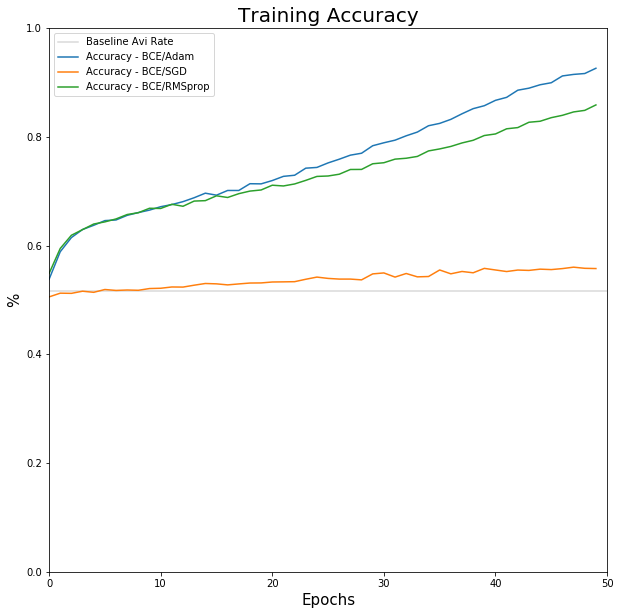

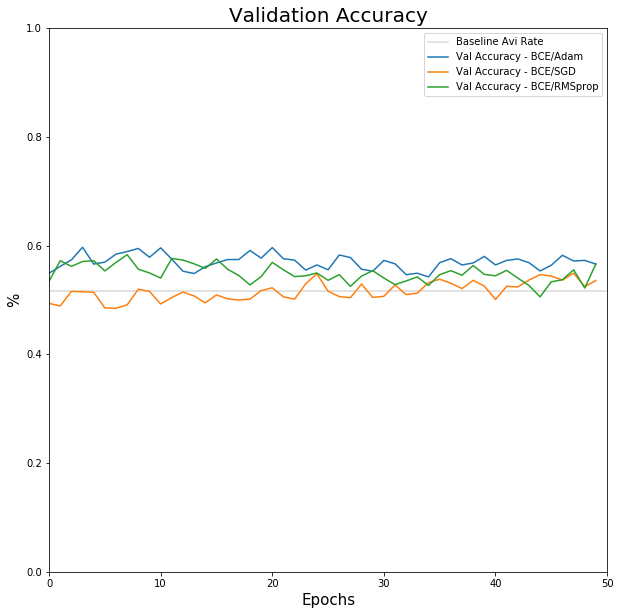

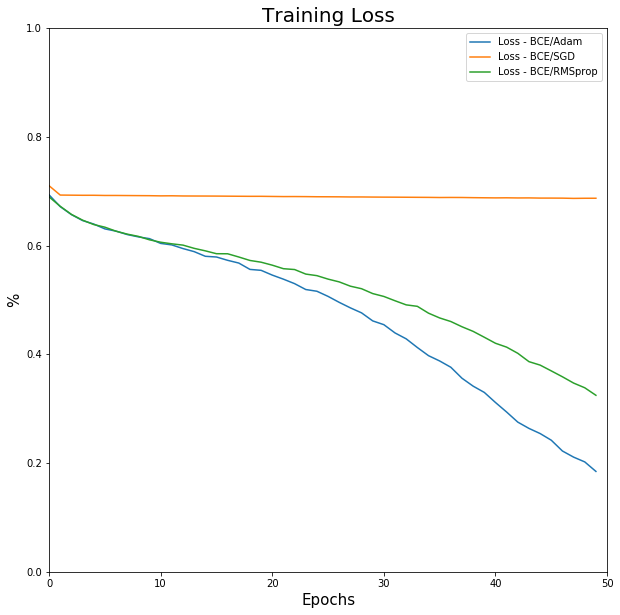

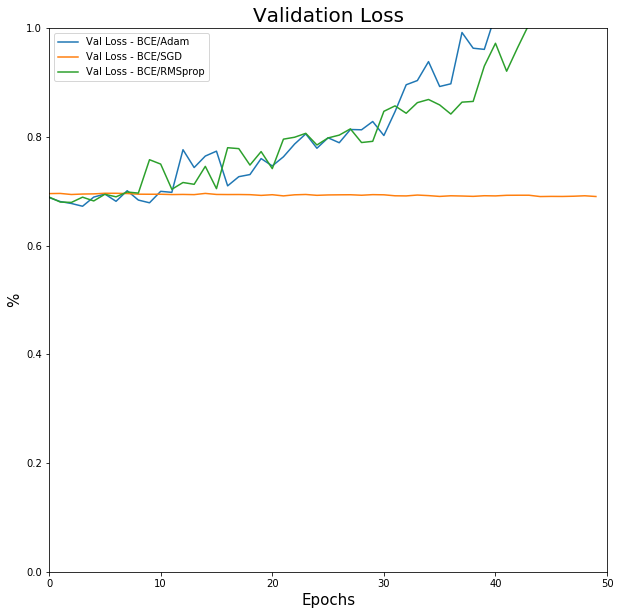

In [120]:
grey = '#d9d9d9'

# plot testing accuracy for each model
plt.figure(2, figsize=(10,10))
ax1 = plt.subplot(1, 1, 1)
ax1.axhline(y=avi_rate/100, xmin=0, xmax=50, color=grey, label='Baseline Avi Rate')
ax1.plot(acc, label='Accuracy - BCE/Adam')
ax1.plot(acc2, label='Accuracy - BCE/SGD')
ax1.plot(acc3, label='Accuracy - BCE/RMSprop')

plt.xlabel('Epochs', size=15)
plt.ylabel('%', size=15)
plt.title('Training Accuracy', size=20)
plt.ylim(0, 1)
plt.xlim(0, epochs)
plt.legend()
plt.show()


# plot validation accuracy for each model
plt.figure(2, figsize=(10,10))
ax2 = plt.subplot(1, 1, 1)
ax2.axhline(y=avi_rate/100, xmin=0, xmax=50, color=grey, label='Baseline Avi Rate')
ax2.plot(val_acc, label='Val Accuracy - BCE/Adam')
ax2.plot(val_acc2, label='Val Accuracy - BCE/SGD')
ax2.plot(val_acc3, label='Val Accuracy - BCE/RMSprop')

plt.xlabel('Epochs', size=15)
plt.ylabel('%', size=15)
plt.title('Validation Accuracy', size=20)
plt.ylim(0, 1)
plt.xlim(0, epochs)
plt.legend()
plt.show()


# plot testing loss for each model
plt.figure(2, figsize=(10,10))
ax2 = plt.subplot(1, 1, 1)
ax2.plot(loss, label='Loss - BCE/Adam')
ax2.plot(loss2, label='Loss - BCE/SGD')
ax2.plot(loss3, label='Loss - BCE/RMSprop')

plt.xlabel('Epochs', size=15)
plt.ylabel('%', size=15)
plt.title('Training Loss', size=20)
plt.ylim(0, 1)
plt.xlim(0, epochs)
plt.legend()
plt.show()


# plot testing loss for each model
plt.figure(2, figsize=(10,10))
ax2 = plt.subplot(1, 1, 1)
ax2.plot(val_loss, label='Val Loss - BCE/Adam')
ax2.plot(val_loss2, label='Val Loss - BCE/SGD')
ax2.plot(val_loss3, label='Val Loss - BCE/RMSprop')

plt.xlabel('Epochs', size=15)
plt.ylabel('%', size=15)
plt.title('Validation Loss', size=20)
plt.ylim(0, 1)
plt.xlim(0, epochs)
plt.legend()
plt.show()

# Plot of ROC curve for each of the models

In [123]:
y_pred_keras = model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

y_pred_keras1 = model1.predict(X_test).ravel()
fpr_keras1, tpr_keras1, thresholds_keras1 = roc_curve(y_test, y_pred_keras1)

y_pred_keras2 = model2.predict(X_test).ravel()
fpr_keras2, tpr_keras2, thresholds_keras2 = roc_curve(y_test, y_pred_keras2)


auc_keras = auc(fpr_keras, tpr_keras)
auc_keras1 = auc(fpr_keras1, tpr_keras1)
auc_keras2 = auc(fpr_keras2, tpr_keras2)

ValueError: Found input variables with inconsistent numbers of samples: [425, 212]

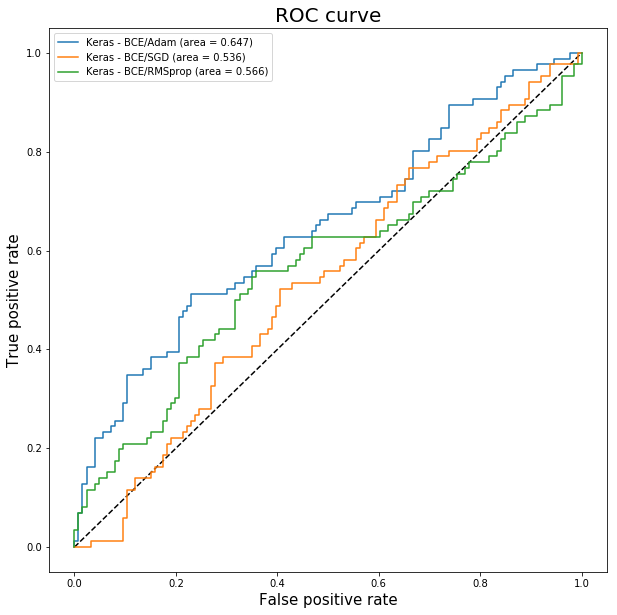

In [122]:
plt.figure(1, figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras - BCE/Adam (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_keras1, tpr_keras1, label='Keras - BCE/SGD (area = {:.3f})'.format(auc_keras1))
plt.plot(fpr_keras2, tpr_keras2, label='Keras - BCE/RMSprop (area = {:.3f})'.format(auc_keras2))
plt.xlabel('False positive rate', size=15)
plt.ylabel('True positive rate', size=15)
plt.title('ROC curve', size=20)
plt.legend(loc='best')
plt.show()